In [1]:
import networkx
import pylab
import numpy as np
from sys import maxsize

In [23]:
# 图类
class GraphGenerator:
    def __init__(self, with_arrow=False,
                 data_file_path=r'E:\OtherProfit\Program\PersonalProfit\Djkstra\source data\graph.txt',
                 pic_save_path=r'E:\OtherProfit\Program\PersonalProfit\Djkstra\PicSaveDir'
                 ):
        self.with_arrow = with_arrow  # 生成图是有向或者无向 fasle为无向，true是有向

        self.node_weight_dic = {}  # 节点权重
        self.graph = self.__generate_graph_with_file(data_file_path)  # 读取文件生成图
        self.adj_dict = self.__generate_adj_dict()  # 生成邻接表
        self.node_names = list(self.graph.node)  # 节点名列表
        self.node_names.sort()

        self.graph_plot(pic_save_path)  # 绘制一下图

    # 读取文件生成图
    def __generate_graph_with_file(self, file_path):
        graph = networkx.Graph()
        if self.with_arrow:
            graph = networkx.DiGraph()
        with open(file_path, 'r') as f:
            for line in f:
                line = line.replace('\n', '')
                param_edge = line.split(',')
                if len(param_edge) < 5:
                    raise 'not enough param parsed at:' + line
                graph.add_edges_from([(param_edge[0], param_edge[1], {'weight': float(param_edge[-1])})])
                if param_edge[0] in self.node_weight_dic and self.node_weight_dic[param_edge[0]] != float(
                        param_edge[2]):
                    raise 'node weight wrong for node %s at: %s' % (param_edge[0], line)
                if param_edge[1] in self.node_weight_dic and self.node_weight_dic[param_edge[1]] != float(
                        param_edge[3]):
                    raise 'node weight wrong for node %s at: %s' % (param_edge[1], line)
                if param_edge[0] not in self.node_weight_dic:
                    self.node_weight_dic[param_edge[0]] = float(param_edge[2])
                if param_edge[1] not in self.node_weight_dic:
                    self.node_weight_dic[param_edge[1]] = float(param_edge[3])
        return graph

    # 可视化有权图
    def graph_plot(self,pic_save_path):
        graph = self.graph
        edge_labels = dict([((u, v,), d['weight'])
                            for u, v, d in graph.edges(data=True)])
        pos = networkx.spring_layout(graph)
        networkx.draw_networkx_edges(graph, pos, arrows=True)
        networkx.draw_networkx_labels(graph, pos)
        networkx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        networkx.draw(graph, pos, node_size=1500, node_color=None, alpha=0.8, arrows=True)
        pylab.savefig(pic_save_path + r'\\Graph.png')
        pylab.show()

    # 由有向图产生邻接表（用dict来表示）
    def __generate_adj_dict(self):
        res_dic = {}
        for key, val in dict(self.graph.adj).items():
            res_dic[key] = dict(val)
        return res_dic

In [28]:
# 改进的Djkstra算法类
class AdvancedDjkstra:
    def __init__(self, graph, load_threshold):
        self.graph_object = graph  # 图类
        self.adj_dic = self.graph_object.adj_dict  # 邻接表
        self.node_weight_dic = self.graph_object.node_weight_dic  # 节点权重表
        self.node_names = self.graph_object.node_names  # 节点名
        self.load_threshold = load_threshold  # 负荷阈值
        self.param_i = 1  # 变量i

        self.node_names = self.graph_object.node_names  # 节点名
        self.if_visited_list = [False for _ in range(len(self.node_names))]  # 记录节点是否已经访问的列表

        self.path_container = []  # 最终要输出的路径集合

    # 统计if_visited_list中为true的节点个数
    def count_node_visited(self):
        return np.sum(self.if_visited_list)

    #  计算 还未访问的所有节点权重之和
    def cal_node_weights_unvisited(self):
        return np.sum([self.node_weight_dic[self.node_names[index]] if not self.if_visited_list[index] else 0
                       for index in range(len(self.node_names))])

    # 查找 还未访问的所有节点中，权重最大的那一个节点索引
    def research_max_weight_node(self):
        return np.argmax([self.node_weight_dic[self.node_names[index]] if not self.if_visited_list[index] else 0
                          for index in range(len(self.node_names))])

    # 输入节点名，检查是否已经访问
    def check_if_visited(self, node_name):
        return self.if_visited_list[self.node_names.index(node_name)]

    # 输入节点名，将该节点设置为已经访问
    def update_if_visited_list(self, node_name):
        self.if_visited_list[self.node_names.index(node_name)] = True

    # 运行主程序
    def advanced_djkstra_engine(self):
        while self.count_node_visited() < len(self.node_names):
            unvisited_nodes_weight = self.cal_node_weights_unvisited()
            if unvisited_nodes_weight > self.load_threshold:
                self.param_i += 1
            path_tmp = []  # 产生一条路径
            start_node_index = self.research_max_weight_node()
            self.if_visited_list[start_node_index] = True
            path_tmp.append(self.node_names[start_node_index])
            path_tmp_weight = self.node_weight_dic[self.node_names[start_node_index]]  # 路径path_tmp所有节点的权重之和
            while path_tmp_weight < self.load_threshold:
                candidate_visit = []
                adj_dic = self.adj_dic[path_tmp[-1]]
                for adj_node_name in adj_dic.keys():
                    tmp_dic = {}
                    tmp_dic['node_name'] = adj_node_name
                    tmp_dic['edge_weight'] = self.node_weight_dic[adj_node_name]
                    if not self.check_if_visited(adj_node_name):
                        candidate_visit.append(tmp_dic)
                # 将邻结点按边权重从大到小排序
                candidate_visit = sorted(candidate_visit, key=lambda x: x['edge_weight'], reverse=True)
                if len(candidate_visit) == 0:
                    break
                if candidate_visit[-1]['edge_weight'] + path_tmp_weight >= self.load_threshold:
                    break
                # 从candidate_visit中搜寻合适的访问结点
                for candidate_node in candidate_visit:
                    if candidate_node['edge_weight'] + path_tmp_weight >= self.load_threshold:
                        continue
                    else:
                        # 找到合适的节点了，吸收这个节点
                        self.update_if_visited_list(candidate_node['node_name'])
                        path_tmp.append(candidate_node['node_name'])
                        path_tmp_weight += candidate_node['edge_weight']
            # 路径生长完成，记录这条路径
            self.path_container.append(path_tmp)
        print('value of param_i:%d' % self.param_i)
        print('path generated:', self.path_container)
        return self.param_i, self.path_container
    

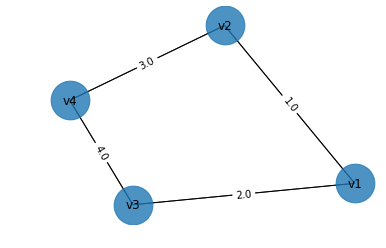

In [29]:
file_path = r'E:\OtherProfit\Program\PersonalProfit\Djkstra\source data\graph_data.txt'
graph_generator = GraphGenerator(with_arrow=False, data_file_path=file_path)


In [30]:
advanced_djkstra = AdvancedDjkstra(graph_generator, load_threshold=5)

In [31]:
advanced_djkstra.advanced_djkstra_engine()

value of param_i:3
path generated: [['v1'], ['v2', 'v4'], ['v3']]


(3, [['v1'], ['v2', 'v4'], ['v3']])

{'v1': 4.0, 'v2': 3.0, 'v4': 1.0, 'v3': 2.0}